### torch实现DeepONet

算子是一个函数空间到函数空间上的映射O：X→X。广义上的算子可以推广到任何空间，如内积空间等。使用DeepONet求解PDE，我们的目标就是要学得一个算子。例如，对于微分方程：
$$
\mathcal{F}(u(z);\gamma)=f(z),z\in \Omega\\
\mathcal{B}(u(z))=g(z),z\in \partial \Omega
$$
我们的目标就是求得算子$G:f\mapsto u$，且$u$满足上述边界条件

DeepONet的思想大致如下图：
<div align=center><img src="1.jpg"></div>

首先解释一下图中的符号。我们的目标是让神经网络学习算子G，因此需要输入一组函数u，先讨论一次输入，即这次输入应该先固定一个特定的函数u，在$x=[x_1,...x_m]$这些点上可以得到确定的一组$u(x)=[u(x_1),...,u(x_n)]$值。而y代表我们学习到的函数$G(u)$的自变量。它可以也可以不和$x$的位置相同，在以下代码实现中应与x相同。   
A表示神经网络的输入和输出。其中输入为u,用离散形式表示，即输入为一串$x_i$和对应的$u(x_i)$,以及我们想要求的对应函数的自变量y，输出为$G(u)(y)$，也即神经网络为算子G，我们把u代入，得到$G(u)$，然后通过$G(u)(y)$的离散形式表示出$G(u)$，也即B中的示意图所表示的内容。输入u通过Branch net进行处理，C和D分别表示了stacked DeepONet(即不同的点$u(x_i)$都对应着不同的p个branch net)和unstacked DeepONet(即不同的点$u(x_i)$都使用同一个个branch net)，y均通过Trunk net，然后将branch net和Trunk net的输出结果做内积即为输出。公式如下：
$$
G(u)(y)\approx \sum\limits_{k=1}^{p}\underbrace{b_k(u(x_1),\dots,u(x_m))}_{branch}\underbrace{t_k(y)}_{trunk}
$$

我们以学习积分算子为例，具体问题如下：  
需要学习的算子$$G:v\mapsto u$$满足ODE方程$$\frac{du(x)}{dx}=v(x),x\in [0,1],$$
边界条件为$u(0)=0$  
我们有的训练数据集为$(x_i,u(x_i))$(在该例子中有150个，每个u有100个x)以及与之相对应的函数$G(u)$，函数G(u)的输入为y，用一串$G(u)(y)$的值来表示$G(u)$，在该例子中，y的取值与x取值相同。
训练数据集为"antiderivative_aligned_train.npz"，测试数据集为"antiderivative_aligned_test.npz"

首先导入需要的库

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

接下来导入数据集。  
该网络中的一个数据点为一对$(v,u)$(在该数据集中我们有150个这样的函数对，另外还有1000个函数对作为测试集，通过numpy读入数据之后转化为tensor)。我们通过如下方法生成：  
1.函数$v$在Gaussian random field (GRF) 上随机取点（这里取m=100个点）  
2.通过数值算法求解$u$。对于每个$u$，我们有100个u(x)的值，且每个$u$所取的x相同，也即我们有$N_u=100$个x。    

In [15]:
d=np.load("antiderivative_aligned_train.npz",allow_pickle=True)
X_train=(d["X"][0].astype(np.float32),d["X"][1].astype(np.float32))
y_train=d["y"].astype(np.float32)
X_train=[torch.from_numpy(X_train[0]),torch.from_numpy(X_train[1])]
y_train=torch.from_numpy(y_train)
print(X_train[0].shape,X_train[1].shape,y_train.shape)
d=np.load("antiderivative_aligned_test.npz",allow_pickle=True)
X_test=(d["X"][0].astype(np.float32),d["X"][1].astype(np.float32))
y_test=d["y"].astype(np.float32)
X_test=[torch.from_numpy(X_test[0]),torch.from_numpy(X_test[1])]
y_test=torch.from_numpy(y_test)
print(X_test[0].shape,X_test[1].shape,y_test.shape)

torch.Size([150, 100]) torch.Size([100, 1]) torch.Size([150, 100])
torch.Size([1000, 100]) torch.Size([100, 1]) torch.Size([1000, 100])


定义网络，branch net和trunk net都是由FNN构成，因此我们先定义FNN类，即由几层线性层和激活函数构成，初始化时输入为列表，其中包含每一层神经网络神经元的个数

In [4]:
from typing import List

def FNN(layer_size:List):
    dense=[]
    for i in range(1,len(layer_size)-1):
        dense.append(nn.Linear(layer_size[i-1],layer_size[i]))#线性层
        dense.append(nn.ReLU())#激活函数
    dense.append(nn.Linear(layer_size[-2],layer_size[-1]))
    return nn.Sequential(*dense)

接下来定义DeepONet网络，初始化时输入branch net和trunk net各层的神经元的个数，输入数据为上述所说的x,u(x),y,输出为$G(u)(y)$

In [5]:
class DeepONet(nn.Module):
    def __init__(self,layer_size_branch,layer_size_trunk) -> None:
        super().__init__()
        self.branch=FNN(layer_size_branch)
        self.trunk=FNN(layer_size_trunk)
    def forward(self,x):
        b=self.branch(x[0])
        t=self.trunk(x[1])
        return torch.mm(b,t.T)

m=100
dim_x=1
layer_size_branch=[m,40,40]
layer_size_trunk=[dim_x,40,40]
net=DeepONet(layer_size_branch,layer_size_trunk)
print(net)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=100, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=40, bias=True)
  )
)


接下来进行训练过程，误差计算采用MSEloss，优化方法采用Adam.  
训练中，branch net 将$150\times 100$的矩阵变成$150\times 40$的矩阵，trunk net将$100\times 1$的矩阵变成$100\times 40$的矩阵，将后一个矩阵转置后，两矩阵相乘得到$150\times 100$的矩阵，然后可以进行误差计算

In [17]:
optimizer=torch.optim.Adam(net.parameters(),lr=0.001)
loss_func=nn.MSELoss()
EPOCH=10000
for epoch in range(EPOCH):
    output=net(X_train)
    loss=loss_func(output,y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%1000==0:
        print('epoch:{}'.format(epoch))
        print('train_loss:{:.8f}'.format(loss.detach().numpy()))
        test_output=net(X_test)
        test_loss=loss_func(test_output,y_test)
        print('test_loss:{:.8f}'.format(test_loss.detach().numpy()))

epoch:0
train_loss:0.00006020
test_loss:0.00602081
epoch:1000
train_loss:0.00000354
test_loss:0.00000537
epoch:2000
train_loss:0.00000387
test_loss:0.00000579
epoch:3000
train_loss:0.00000915
test_loss:0.00001203
epoch:4000
train_loss:0.00000818
test_loss:0.00001011
epoch:5000
train_loss:0.00000472
test_loss:0.00000688
epoch:6000
train_loss:0.00000347
test_loss:0.00000582
epoch:7000
train_loss:0.00000308
test_loss:0.00000530
epoch:8000
train_loss:0.00009575
test_loss:0.00011659
epoch:9000
train_loss:0.00000285
test_loss:0.00000486


利用求得的算子来计算y=x的积分，并与实际的函数$y=\frac{1}{2}$做对比，结果如下

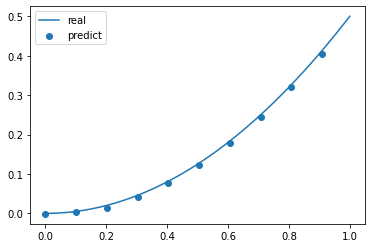

In [9]:
import copy
x=X_train[1].reshape(1,100)
y=copy.copy(X_train[1])
result=net((x,y))
plt.plot(x.detach().numpy().reshape(100),0.5*x.detach().numpy().reshape(100)**2,label='real')
plt.scatter(x.detach().numpy().reshape(100)[::10],result.detach().numpy().reshape(100)[::10],label='predict')
plt.legend(loc='best')
plt.show()